## DFO Nutrient Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=12)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=12)
mpl.rc('font', size=12)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

%matplotlib inline

In [2]:
PATH= '/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}
df1=et.loadDFO()
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
#data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)
data=pickle.load(open('/data/eolson/MEOPAR/SS36runs/calcFiles/evalMatches/dataDFO.pkl','rb'))

In [4]:
def rotmap(lon,lat,lon0,lat0,phi):
    # rotate around point (pick one near center of domain)
    # phi in degrees
    # first scale lats to match and center around lat0,lon0:
    lon1=(lon-lon0)*np.cos(lat0*np.pi/180)
    lat1=lat-lat0
    # now rotate:
    lon2=lon1*np.cos(phi*np.pi/180)-lat1*np.sin(phi*np.pi/180)
    lat2=lon1*np.sin(phi*np.pi/180)+lat1*np.cos(phi*np.pi/180)
    return lon2,lat2

In [5]:
cm1=cmocean.cm.thermal
#plt.get_cmap('PuBuGn')
#cm1=cmo.cm.matter
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])
blon,blat=rotmap(bathylon,bathylat,lon0,lat0,theta)

In [6]:
mod_chl_N=1.6
#mod_chl_N=2.0
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
#data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

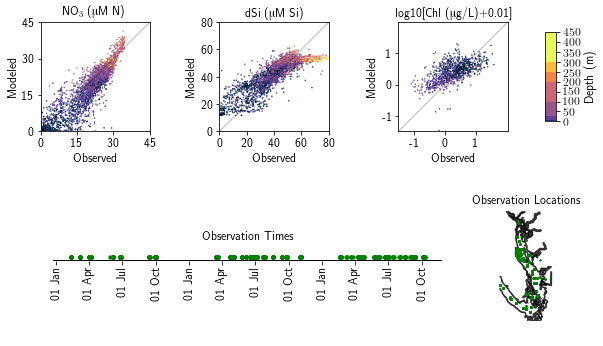

In [33]:
bounds = np.array([0,5,10,35,100,200,250,300,450])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')

fig = plt.figure(figsize = (9,5))
gsv = gridspec.GridSpec(2,1,left=.08,right=1.05,hspace=.3,bottom=.05,top=.94,height_ratios=[1.2,1.0])
gs1=gridspec.GridSpecFromSubplotSpec(1,5,subplot_spec=gsv[0],wspace=1.0,hspace=.34,width_ratios=[1,1,1,.1,.1])
axN=fig.add_subplot(gs1[0])
axSi = fig.add_subplot(gs1[1])
axChl = fig.add_subplot(gs1[2])
gscb=gridspec.GridSpecFromSubplotSpec(5,1,subplot_spec=gs1[:,3])
axcb = fig.add_subplot(gscb[1:-1])

gsL=gridspec.GridSpecFromSubplotSpec(4,2,wspace=0.2,subplot_spec=gsv[1],width_ratios=[1,1.],height_ratios=[.22,.36,1,1])
#axL2015=fig.add_subplot(gsL[0,0])
axL=fig.add_subplot(gsL[1,0])
#axL2017=fig.add_subplot(gsL[2,0])
axLmap=fig.add_subplot(gsL[1:,1])

for ax in (axN,):
    ax.plot((0,45),(0,45),'k-',alpha=.2)
for ax in (axSi,):
    ax.plot((0,80),(0,80),'k-',alpha=.2)
for ax in (axChl,):
    ax.plot((-2,2),(-2,2),'k-',alpha=.2)

vm0=-150
args={'marker':'.','s':1,'norm':norm}
ps=et.varvarScatter(axN,data,'N','mod_nitrate','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(axSi,data,'Si','mod_silicon','Z',vmin=vm0,vmax=450,cm=cm1,args=args)
ps=et.varvarScatter(axChl,data,'l10_obsChl','l10_modChl','Z',vmin=vm0,vmax=450,cm=cm1,args=args)

cb=fig.colorbar(ps,cax=axcb,boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')
#cb.set_ylim(0,450)

ntick=np.arange(0,56,15)
ntickl=[str(i) for i in ntick]
for ax in (axN,):
    ax.set_xlim((0,45))
    ax.set_ylim((0,45))
    ax.set_xticks(ntick)
    ax.set_xticklabels(ntickl)
    ax.set_yticks(ntick)
    ax.set_yticklabels(ntickl)
    
stick=np.arange(0,81,20)
stickl=[str(i) for i in stick]
for ax in (axSi,):
    ax.set_xlim((0,80))
    ax.set_ylim((0,80))
    ax.set_xticks(stick)
    ax.set_xticklabels(stickl)
    ax.set_yticks(stick)
    ax.set_yticklabels(stickl)

ctick=np.arange(-1,2,1)
ctickl=[str(i) for i in ctick]
for ax in (axChl,):
    ax.set_xlim((-1.5,2))
    ax.set_ylim((-1.5,2))
    ax.set_xticks(ctick)
    ax.set_xticklabels(ctickl)
    ax.set_yticks(ctick)
    ax.set_yticklabels(ctickl)
    
for ax in (axN,axSi,axChl):
    ax.set_aspect(1, adjustable='box')
    #ax.set_xlabel('Observed')
    
axN.set_ylabel('Modeled')
axSi.set_ylabel('Modeled')
axChl.set_ylabel('Modeled')
axN.set_xlabel('Observed')
axSi.set_xlabel('Observed')
axChl.set_xlabel('Observed')

#axN.annotate('2015',xy=[.5,1.18],xycoords='axes fraction',ha='center')
#ax2016N.annotate('2016',xy=[.5,1.18],xycoords='axes fraction',ha='center')
#ax2017N.annotate('2017',xy=[.5,1.18],xycoords='axes fraction',ha='center')
axN.set_title('NO$_3$ ($\muup$M N)')
axSi.set_title('dSi ($\muup$M Si)')
axChl.set_title('log10[Chl ($\muup$g/L)+0.01]')

#viz_tools.set_aspect(axLmap)
for axLi in (axLmap,):
    axLi.set_aspect(1, adjustable='box')
    contour_lines = axLi.contour(blon,blat,bathyZ,[0],
                colors='black',zorder=2,linewidth=.5,alpha=.8)
    axLi.set_xlim(-1.02,0.81)
    axLi.set_ylim(-1.5,1.8)
    axLi.axis('off')
datanut=data.loc[(data.N>=0)|(data.Si>=0)]
dataChl=data.loc[(data.Chlorophyll_Extracted>=0)]
lons,lats=rotmap(datanut['Lon'], datanut['Lat'],lon0,lat0,theta)
lonschl,latschl=rotmap(dataChl['Lon'], dataChl['Lat'],lon0,lat0,theta)
axLmap.plot(lons,lats, '.',color='green',markersize=2)
axLmap.plot(lonschl,latschl, '.',color='green',markersize=2)
axLmap.set_title('Observation Locations',fontsize=12)

axL.set_title('Observation Times',fontsize=12)
p1a,=axL.plot(datanut.dtUTC,np.zeros(np.shape(datanut.dtUTC)),'.',color='green',markersize=6)
p1,=axL.plot(dataChl.dtUTC,np.zeros(np.shape(dataChl.dtUTC)),'.',color='green',markersize=6,label='2015')
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(2015,1,1), dt.datetime(2015,4,1),dt.datetime(2015,7,1),dt.datetime(2015,10,1),
                     dt.datetime(2016,1,1), dt.datetime(2016,4,1),dt.datetime(2016,7,1),dt.datetime(2016,10,1),
                     dt.datetime(2017,1,1), dt.datetime(2017,4,1),dt.datetime(2017,7,1),dt.datetime(2017,10,1),])
#labels=axL.xaxis.get_ticklabels()
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.3)
axLpos=axL.get_position()
new = mpl.transforms.Bbox.from_bounds(0.1,axLpos.bounds[1]-.1,0.6,axLpos.bounds[3])
axL.set_position(new)
axcbpos=axcb.get_position()
new2=mpl.transforms.Bbox.from_bounds(axcbpos.bounds[0]-.05,axcbpos.bounds[1],axcbpos.bounds[2],axcbpos.bounds[3])
axcb.set_position(new2)
#axL.legend(handles=[p1,p2,p3],loc=8,ncol=3,bbox_to_anchor=[.5,-4])
axL.set_frame_on(False)
#axL.axes.get_yaxis().set_visible(False)
#axL.axes.get_xaxis().set_visible(True)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsEval/dfoEvalIUGG.png',dpi=300,transparent=True)